In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor.EKF import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.data_models.sim import SimConfig
from deorbit.utils.constants import GM_EARTH
import numpy as np


In [7]:
try:
    save_path = "eg/sim_20240505_203529"
    sim_data = load_sim_data(save_path)
    sim_config = load_sim_config(save_path)
except FileNotFoundError:
    sim = deorbit.simulator.run(
        "adams_bashforth",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        time_step=0.1,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data("eg/")

In [8]:
# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.01, 0.01])
R = np.diag([1, 1, 0.1, 0.1])
P = np.diag([1, 1, 1, 1])

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

dt = sim_config.simulation_method_kwargs.time_step

estimated_traj, measurements = EKF(sim_data, dt, Q, R, P, H)

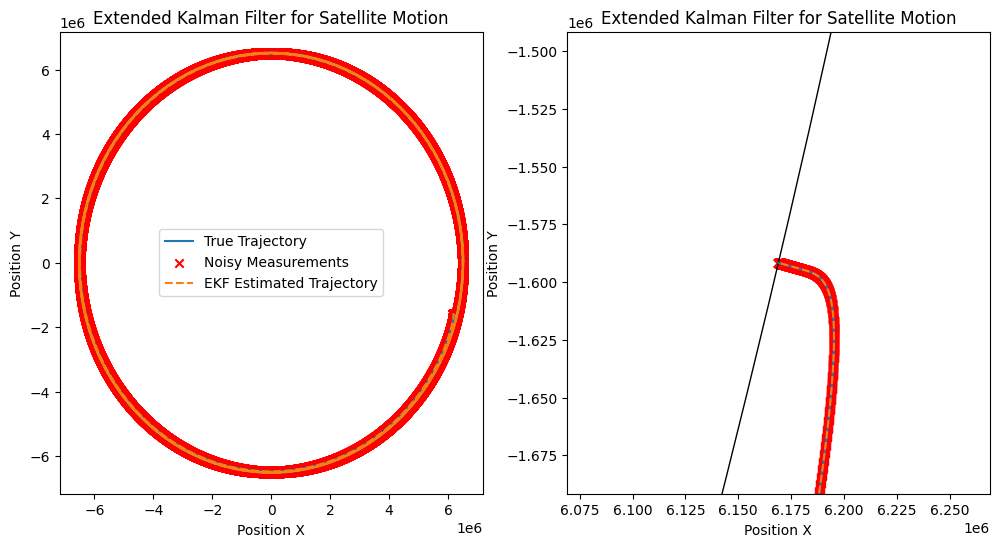

In [9]:

true_traj = np.array([sim_data.x1, sim_data.x2])

crash_coords = true_traj[:, -1]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

ax1.plot(true_traj[0, :], true_traj[1, :], label='True Trajectory')
ax1.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements')
ax1.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')



ax2.plot(true_traj[0, :], true_traj[1, :], label='True Trajectory')
ax2.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements')
ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
ax2.set_title('Extended Kalman Filter for Satellite Motion')
ax2.set_xlabel('Position X')
ax2.set_ylabel('Position Y')
ax2.set_xlim([crash_coords[0]-1e5, crash_coords[0]+1e5])
ax2.set_ylim([crash_coords[1]-1e5, crash_coords[1]+1e5])
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax2.add_patch(earth)
ax1.legend()

plt.show()